## AI 1-hop severity graph and CWE influence analysis

This notebook builds:
- AI 1-hop dependency graph with nodes colored by severity (from merged timeline)
- CWE influence networks and AI-focused CWE propagation metrics

Prerequisites:
- `python_dependencies_edges.csv` in project root
- `outputs/summaries/top_pypi_snyk_timeline_merged.csv` generated by the merge script
- Optional for AI CWE: `outputs/top_pypi_snyk_timeline_20221112_20251112.csv`



In [1]:
# Setup
import os, numpy as np
import pandas as pd, networkx as nx, matplotlib.pyplot as plt
from matplotlib.patches import Patch

os.makedirs('outputs/plots', exist_ok=True)

# Helper to normalize package/node names
def normalize_pkg(name: str) -> str:
    return str(name).strip().lower().replace('_', '-')



In [2]:
# Define AI libraries (edit this list for your focus set)
AI_LIBS = [
    'torch', 'tensorflow', 'keras', 'pytorch-lightning', 'lightning',
    'scikit-learn', 'xgboost', 'lightgbm', 'catboost',
    'transformers', 'sentence-transformers', 'tokenizers',
    'langchain', 'langchain-core', 'langchain-community',
    'llama-index', 'llama-index-core',
    'vllm', 'litellm', 'openai',
    'mlflow', 'wandb', 'clearml', 'sagemaker',
    'gradio', 'streamlit',
    'opencv-python', 'pillow'
]
print(f"AI_LIBS: {len(AI_LIBS)} items")



AI_LIBS: 28 items


## CWE influence network (merged timeline window)

This section builds a directed CWE co-occurrence graph from the merged timeline, filters by date, and computes centrality metrics and plots.



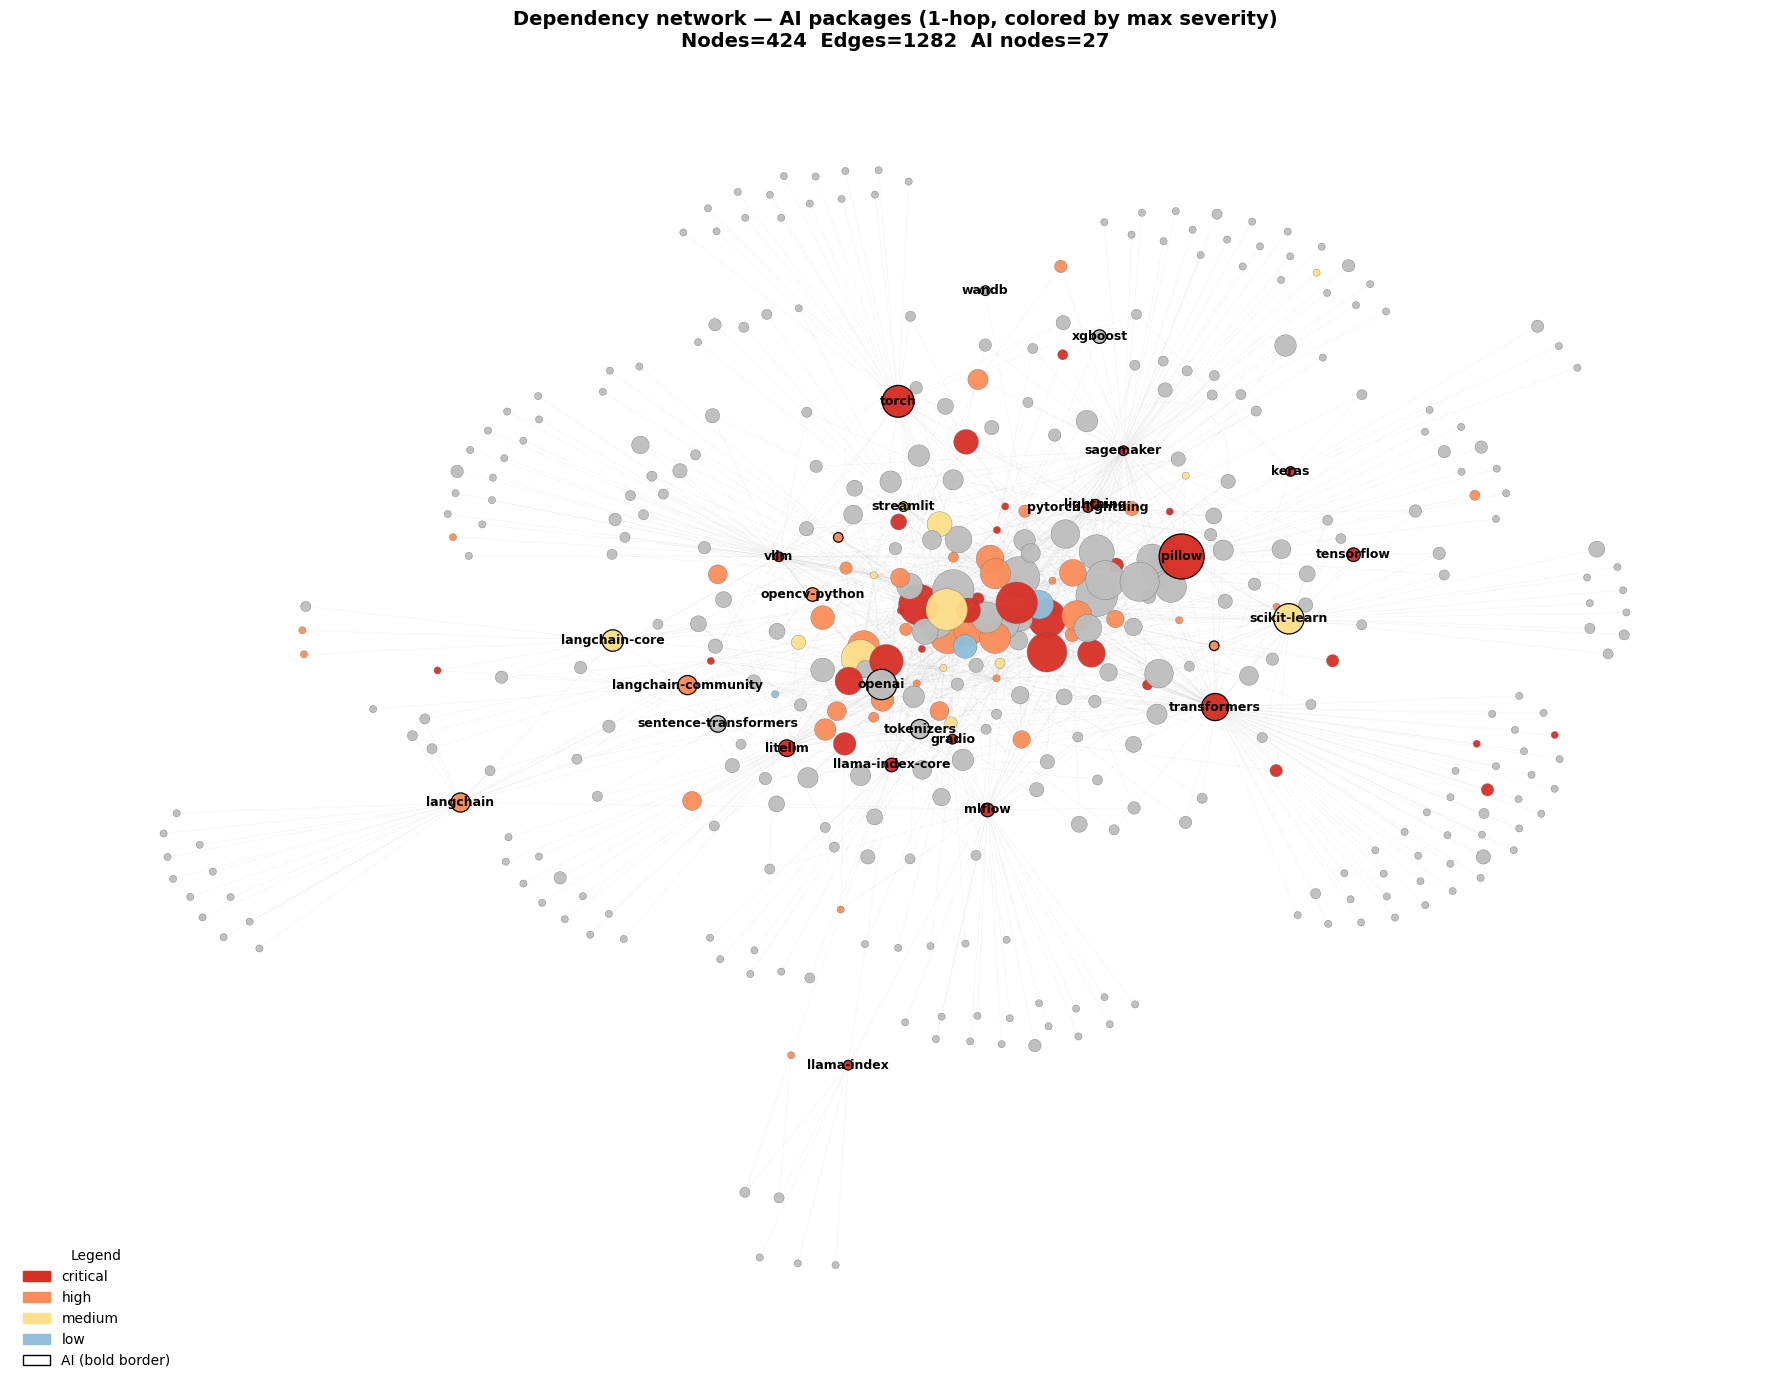

In [7]:
# Force merged-only severity map + AI 1-hop graph colored by severity
import os, numpy as np, pandas as pd, networkx as nx, matplotlib.pyplot as plt
from matplotlib.patches import Patch

def normalize_pkg(s): return str(s).strip().lower().replace('_','-')

# Graph (prefer enriched edges if present)
edges_path = 'outputs/summaries/python_dependencies_edges_enriched.csv'
if not os.path.exists(edges_path): edges_path = 'python_dependencies_edges.csv'
edges = pd.read_csv(edges_path)
edges['source'] = edges['source'].map(normalize_pkg); edges['target'] = edges['target'].map(normalize_pkg)
DG_all = nx.DiGraph(); DG_all.add_edges_from(edges[['source','target']].itertuples(index=False, name=None))
UG_all = DG_all.to_undirected()

# Severity from MERGED ONLY
merged = 'outputs/summaries/top_pypi_snyk_timeline_merged.csv'
vulns = pd.read_csv(merged)
vulns['package'] = vulns['package'].map(normalize_pkg)
vulns['severity'] = vulns['severity'].astype(str).str.lower().fillna('unknown')
sev_rank = {'low':1,'medium':2,'moderate':2,'high':3,'critical':4}
vulns['sev_rank'] = vulns['severity'].map(lambda s: sev_rank.get(s,0))
agg = vulns.groupby('package', as_index=False)['sev_rank'].max()
inv = {v:k for k,v in sev_rank.items()}
agg['severity_max'] = agg['sev_rank'].map(lambda r: inv.get(r,'unknown'))
pkg_sev = dict(zip(agg['package'], agg['severity_max']))
color_map = {'critical':'#d73027','high':'#fc8d59','medium':'#fee08b','moderate':'#fee08b','low':'#91bfdb','unknown':'#bdbdbd'}

# AI list
try: AI_LIBS
except NameError:
    AI_LIBS = ['torch','transformers','langchain','llama-index','openai','gradio','fastapi','mlflow','pytorch-lightning','tensorflow']

ai_nodes = {normalize_pkg(p) for p in AI_LIBS if normalize_pkg(p) in DG_all}
ai_focus = set(ai_nodes)
for n in list(ai_nodes):
    ai_focus.update(DG_all.predecessors(n)); ai_focus.update(DG_all.successors(n))
H = UG_all.subgraph(ai_focus).copy()

if H.number_of_nodes()==0:
    print('Empty AI 1-hop graph'); 
else:
    comps = sorted(nx.connected_components(H), key=len, reverse=True); H = H.subgraph(comps[0]).copy()
    k = 1/np.sqrt(max(H.number_of_nodes(),1)); pos = nx.spring_layout(H, k=k*3, iterations=450, seed=23)
    indeg = dict(DG_all.in_degree(H.nodes()))
    base = np.array([max(1, indeg.get(n,0)) for n in H.nodes()]); p95 = np.percentile(base,95) if np.any(base) else 1.0
    sizes = (base/p95 * 500).clip(10, 900)
    ai_set = set(ai_nodes) & set(H.nodes()); sizes_ai = np.clip([(max(1,indeg.get(n,0))/p95*900) for n in ai_set], 40, 1400)
    def sev(n):
        s = str(pkg_sev.get(normalize_pkg(n), 'unknown')).lower()
        return 'medium' if s=='moderate' else s

    fig, ax = plt.subplots(1,1, figsize=(18,14))
    nx.draw_networkx_edges(H, pos, ax=ax, width=0.35, alpha=0.14, edge_color='#9e9e9e')
    idx = {n:i for i,n in enumerate(H.nodes())}
    ctx_nodes = [n for n in H.nodes() if n not in ai_set]
    ctx_sizes = [sizes[idx[n]] for n in ctx_nodes]
    ctx_colors = [color_map.get(sev(n), color_map['unknown']) for n in ctx_nodes]
    nx.draw_networkx_nodes(H, pos, nodelist=ctx_nodes, node_size=ctx_sizes, node_color=ctx_colors,
                           edgecolors='#666666', linewidths=0.25, alpha=0.95, ax=ax)
    nx.draw_networkx_nodes(H, pos, nodelist=list(ai_set), node_size=sizes_ai,
                           node_color=[color_map.get(sev(n), color_map['unknown']) for n in ai_set],
                           edgecolors='black', linewidths=0.9, alpha=0.98, ax=ax)
    hubs = sorted([(n, indeg.get(n,0)) for n in ai_set], key=lambda x:x[1], reverse=True)[:25]
    nx.draw_networkx_labels(H, pos, labels={n:n for n,_ in hubs}, font_size=9, font_weight='bold', ax=ax)
    leg = [Patch(color=color_map['critical'],label='critical'),Patch(color=color_map['high'],label='high'),
           Patch(color=color_map['medium'],label='medium'),Patch(color=color_map['low'],label='low'),
           Patch(facecolor='white',edgecolor='black',label='AI (bold border)')]
    ax.legend(handles=leg, title='Legend', frameon=False, loc='lower left')
    ax.set_title(f"Dependency network — AI packages (1-hop, colored by max severity)\nNodes={H.number_of_nodes()}  Edges={H.number_of_edges()}  AI nodes={len(ai_set)}",
                 fontsize=14, fontweight='bold')
    ax.axis('off'); plt.tight_layout()
    plt.savefig('outputs/plots/dependency_severity_ai_1hop_colored.png', dpi=300, bbox_inches='tight')
    plt.savefig('outputs/plots/dependency_severity_ai_1hop.png', dpi=300, bbox_inches='tight')
    plt.show()

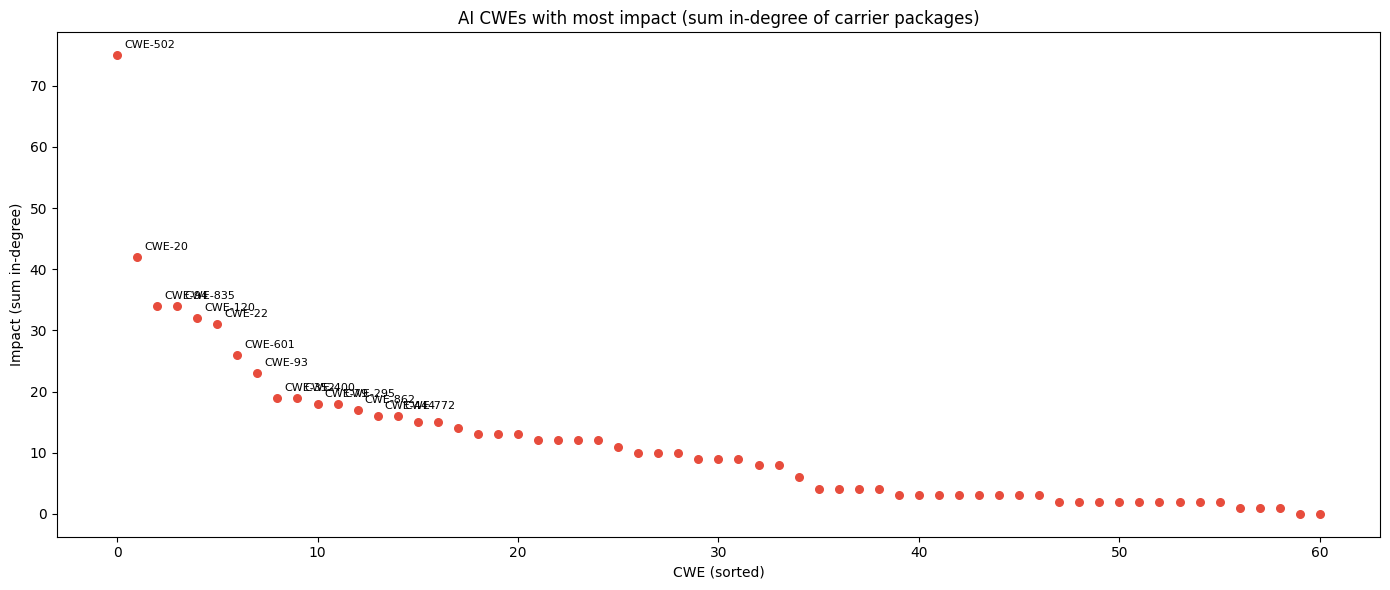

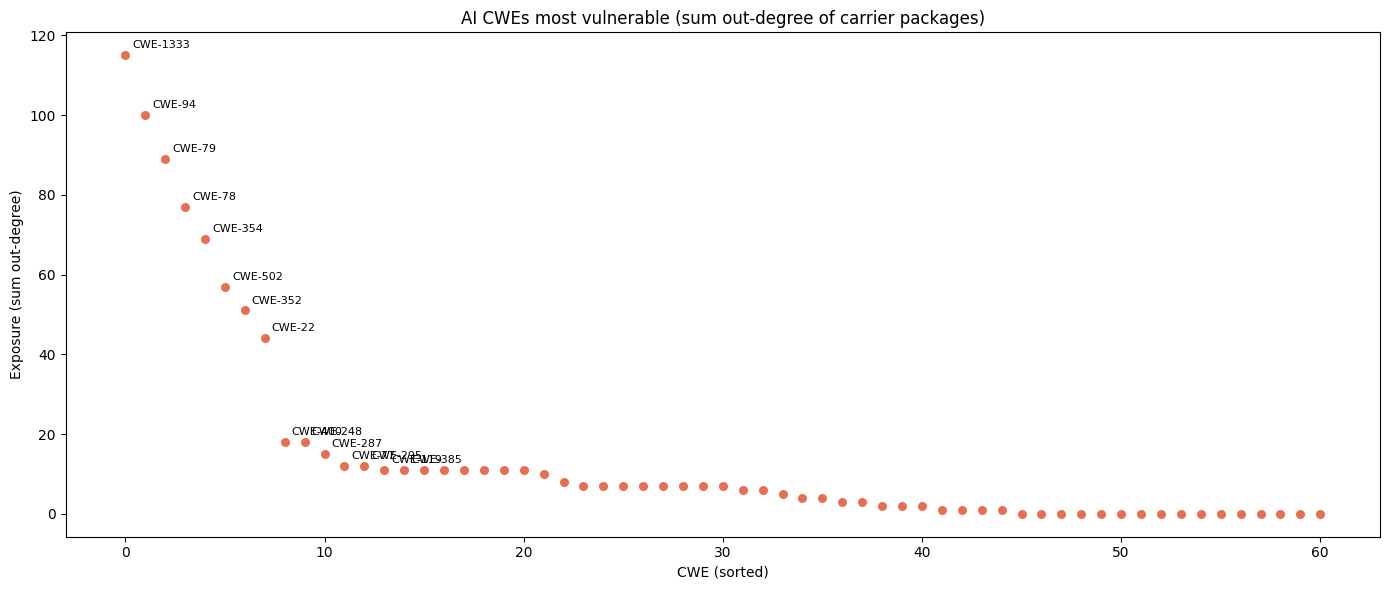

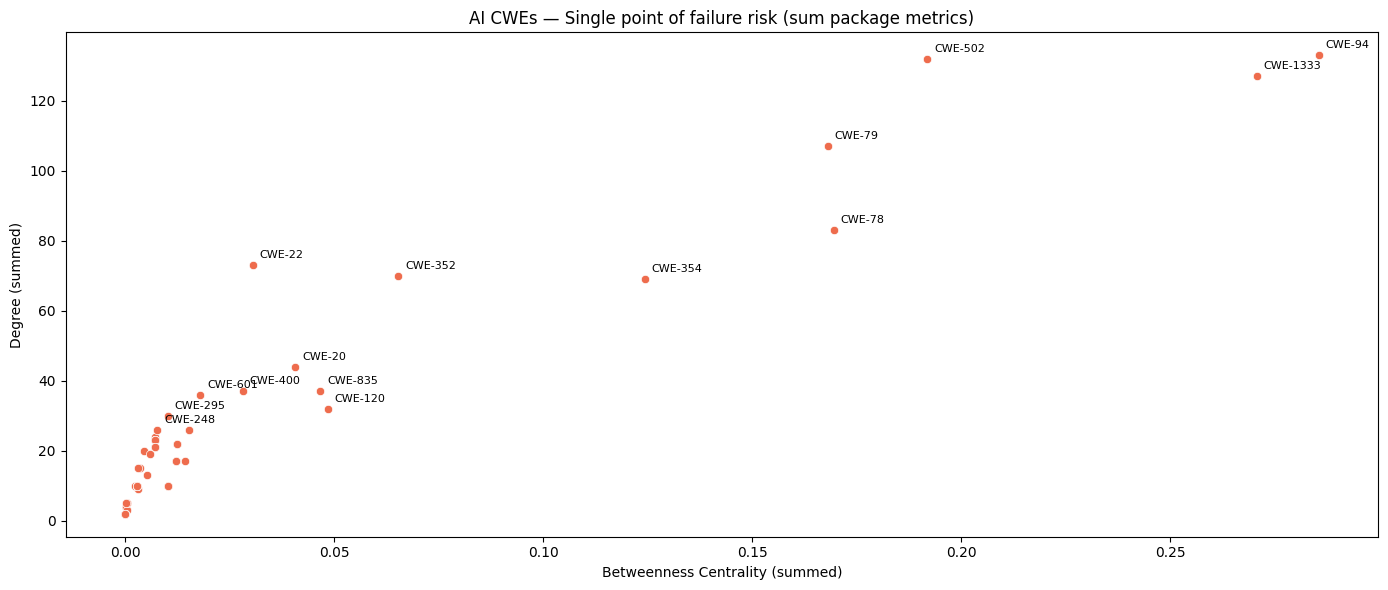

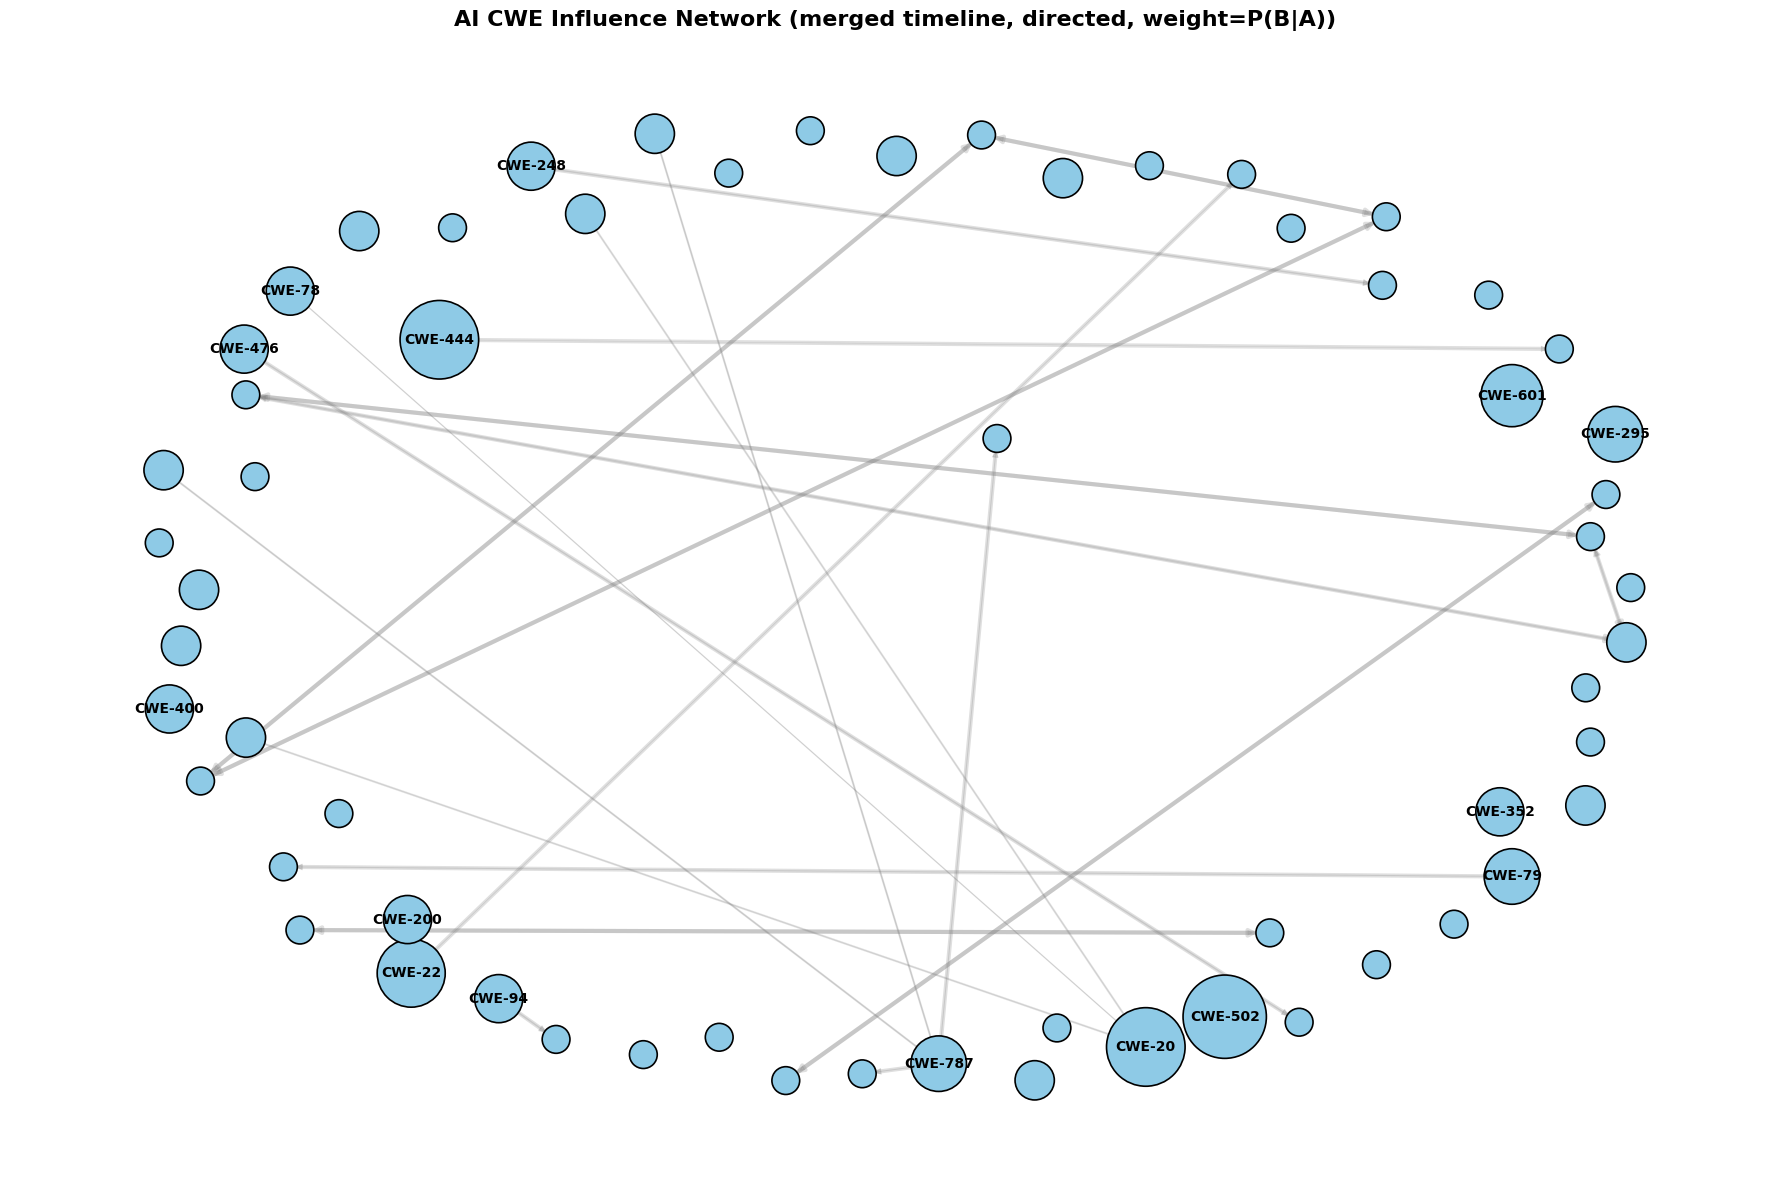

In [8]:
# CWE impact from merged-only + AI 1-hop package centrality
import json, re, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, networkx as nx
from collections import defaultdict

def parse_cwes(val):
    if pd.isna(val): return []
    s = str(val).strip()
    if s.startswith('[') and s.endswith(']'):
        try:
            arr = json.loads(s); out=[]
            for x in arr: out += re.findall(r'CWE-\d+', str(x).upper())
            return list(dict.fromkeys(out))
        except Exception: pass
    out=[]
    for p in re.split(r'[;,\s]+', s):
        up=p.strip().upper()
        if up.startswith('CWE-'): out.append(up)
    return list(dict.fromkeys(out))

# Use merged only
merged = 'outputs/summaries/top_pypi_snyk_timeline_merged.csv'
dfm = pd.read_csv(merged)
dfm['package'] = dfm['package'].map(normalize_pkg)
dfm['cwe_list'] = (dfm['cwes'] if 'cwes' in dfm.columns else dfm['CWE'] if 'CWE' in dfm.columns else pd.Series(['']*len(dfm))).apply(parse_cwes)

# Keep only packages in the AI 1-hop subgraph H
if H.number_of_nodes()==0:
    raise SystemExit('AI 1-hop graph is empty — run previous cell first')
aih_nodes = set(H.nodes())
df_ai = dfm[dfm['package'].isin(aih_nodes)].copy()

# Package centralities within H
UG = H
DG = DG_all.subgraph(H.nodes()).copy()
deg = dict(UG.degree())
btw = nx.betweenness_centrality(UG, normalized=True) if UG.number_of_edges()>0 else {n:0 for n in UG.nodes()}
in_deg = dict(DG.in_degree())
out_deg = dict(DG.out_degree())

pkg_metrics = pd.DataFrame({
    'package': list(UG.nodes()),
    'deg': [deg.get(n,0) for n in UG.nodes()],
    'betweenness': [btw.get(n,0.0) for n in UG.nodes()],
    'in_deg': [in_deg.get(n,0) for n in UG.nodes()],
    'out_deg': [out_deg.get(n,0) for n in UG.nodes()],
})

# Aggregate to CWE by summing carrier-package metrics (impact on network)
pkg2cwes = df_ai.groupby('package')['cwe_list'].apply(lambda col: list({c for lst in col for c in lst})).to_dict()
cwe_rows = []
for pkg, cwes in pkg2cwes.items():
    m = pkg_metrics[pkg_metrics['package']==pkg]
    if m.empty: continue
    for c in cwes:
        cwe_rows.append([c, int(m['in_deg'].iat[0]), int(m['out_deg'].iat[0]), float(m['deg'].iat[0]), float(m['betweenness'].iat[0])])
cwe_df = pd.DataFrame(cwe_rows, columns=['cwe','in_deg','out_deg','deg','betweenness'])
if cwe_df.empty:
    raise SystemExit('No CWE data mapped to AI 1-hop nodes in merged file')

cwe_agg = cwe_df.groupby('cwe', as_index=False).sum().sort_values(['in_deg','out_deg'], ascending=False)
cwe_agg.to_csv('outputs/summaries/ai_cwe_network_impact.csv', index=False)

# Plots analogous to package impact (in/out/ SPOF)
# In-degree impact (influence)
vals = cwe_agg[['cwe','in_deg']].sort_values('in_deg', ascending=False).reset_index(drop=True)
fig, ax = plt.subplots(1,1, figsize=(14,6))
ax.scatter(range(len(vals)), vals['in_deg'], c='#e74c3c', s=30)
for i,row in vals.head(15).iterrows(): ax.annotate(row['cwe'], (i, row['in_deg']), xytext=(5,5), textcoords='offset points', fontsize=8)
ax.set_title('AI CWEs with most impact (sum in-degree of carrier packages)'); ax.set_xlabel('CWE (sorted)'); ax.set_ylabel('Impact (sum in-degree)')
plt.tight_layout(); plt.savefig('outputs/plots/cwe_in_degree_impact_ai.png', dpi=300, bbox_inches='tight'); plt.show()

# Out-degree vulnerability (exposure)
vals2 = cwe_agg[['cwe','out_deg']].sort_values('out_deg', ascending=False).reset_index(drop=True)
fig, ax = plt.subplots(1,1, figsize=(14,6))
ax.scatter(range(len(vals2)), vals2['out_deg'], c='#e76f51', s=30)
for i,row in vals2.head(15).iterrows(): ax.annotate(row['cwe'], (i, row['out_deg']), xytext=(5,5), textcoords='offset points', fontsize=8)
ax.set_title('AI CWEs most vulnerable (sum out-degree of carrier packages)'); ax.set_xlabel('CWE (sorted)'); ax.set_ylabel('Exposure (sum out-degree)')
plt.tight_layout(); plt.savefig('outputs/plots/cwe_out_degree_impact_ai.png', dpi=300, bbox_inches='tight'); plt.show()

# SPOF: Degree vs Betweenness (CWE-level by summed package metrics)
fig, ax = plt.subplots(1,1, figsize=(14,6))
sns.scatterplot(data=cwe_agg, x='betweenness', y='deg', color='#ee6c4d', ax=ax)
for _,row in cwe_agg.sort_values('deg', ascending=False).head(15).iterrows():
    ax.annotate(row['cwe'], (row['betweenness'], row['deg']), xytext=(5,5), textcoords='offset points', fontsize=8)
ax.set_title('AI CWEs — Single point of failure risk (sum package metrics)'); ax.set_xlabel('Betweenness Centrality (summed)'); ax.set_ylabel('Degree (summed)')
plt.tight_layout(); plt.savefig('outputs/plots/cwe_degree_vs_betweenness_ai.png', dpi=300, bbox_inches='tight'); plt.show()

# Co-occurrence network from merged (relaxed thresholds so edges appear)
pairs = defaultdict(int); freq = defaultdict(int)
for lst in df_ai['cwe_list']:
    uu = sorted(set(lst))
    for c in uu: freq[c]+=1
    for i in range(len(uu)):
        for j in range(i+1,len(uu)):
            pairs[(uu[i],uu[j])] += 1; pairs[(uu[j],uu[i])] += 1

MIN_PAIR, MIN_P = 1, 0.05
G_cwe = nx.DiGraph()
for c,f in freq.items(): G_cwe.add_node(c, freq=f)
for (a,b),cnt in pairs.items():
    if freq[a]>0:
        p = cnt/freq[a]
        if cnt>=MIN_PAIR and p>=MIN_P: G_cwe.add_edge(a,b,weight=p,count=cnt)

pos = nx.spring_layout(G_cwe, weight='weight', seed=42, k=2) if G_cwe.number_of_edges()>0 else {n:(i,0) for i,n in enumerate(G_cwe.nodes())}
node_size=[400*(G_cwe.nodes[n].get('freq',1)) for n in G_cwe.nodes()]
edge_w=[d.get('weight',0.1)*3 for _,_,d in G_cwe.edges(data=True)]
fig, ax = plt.subplots(1,1, figsize=(18,12))
nx.draw_networkx_edges(G_cwe,pos,alpha=0.25,width=edge_w,arrows=True,arrowstyle='-|>',arrowsize=10,edge_color='gray',ax=ax)
nx.draw_networkx_nodes(G_cwe,pos,node_color='#8ecae6',node_size=node_size,edgecolors='black',linewidths=1.2,ax=ax)
labels={n:n for n in sorted(freq,key=freq.get,reverse=True)[:15]}
nx.draw_networkx_labels(G_cwe,pos,labels=labels,font_size=10,font_weight='bold',ax=ax)
ax.set_title('AI CWE Influence Network (merged timeline, directed, weight=P(B|A))',fontsize=16,fontweight='bold'); ax.axis('off')
plt.tight_layout(); plt.savefig('outputs/plots/cwe_influence_network.png',dpi=300,bbox_inches='tight'); plt.show()

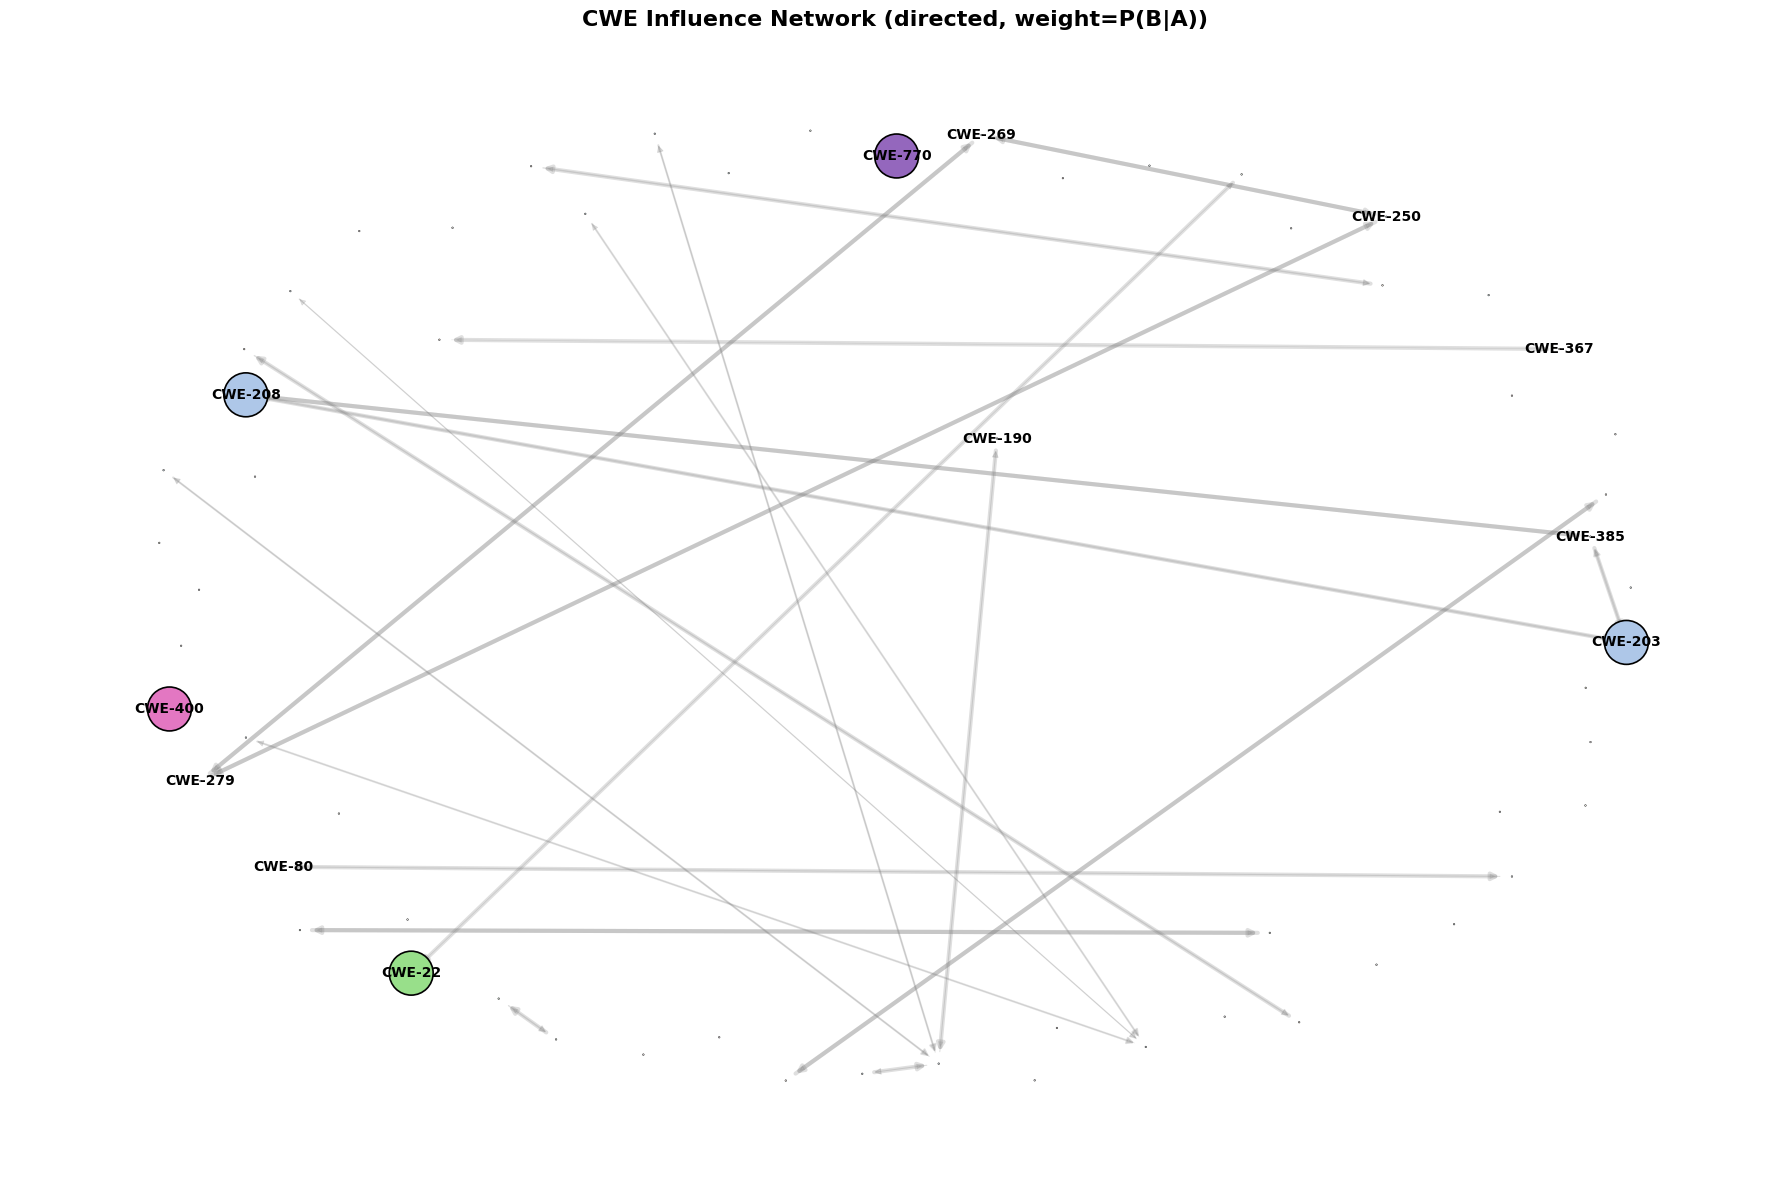

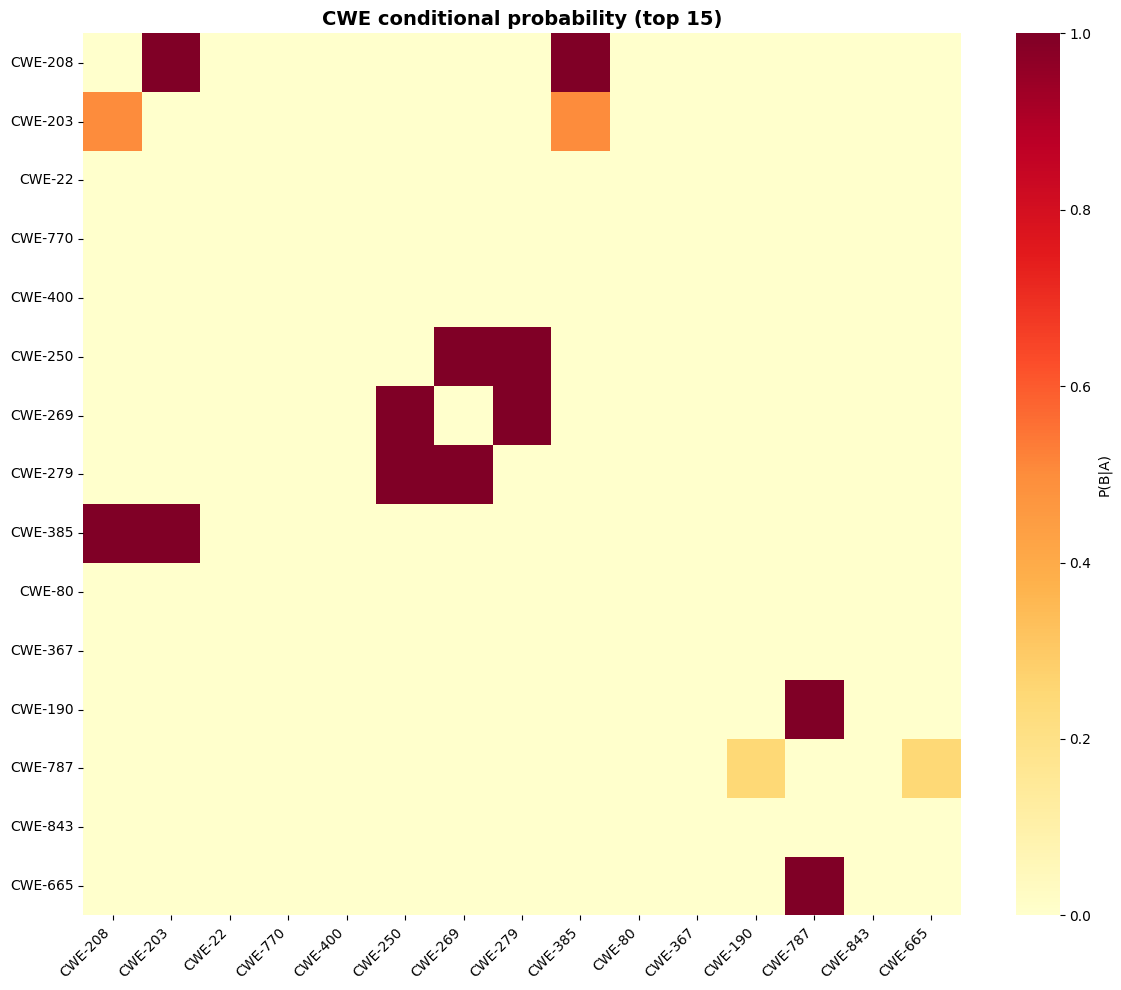

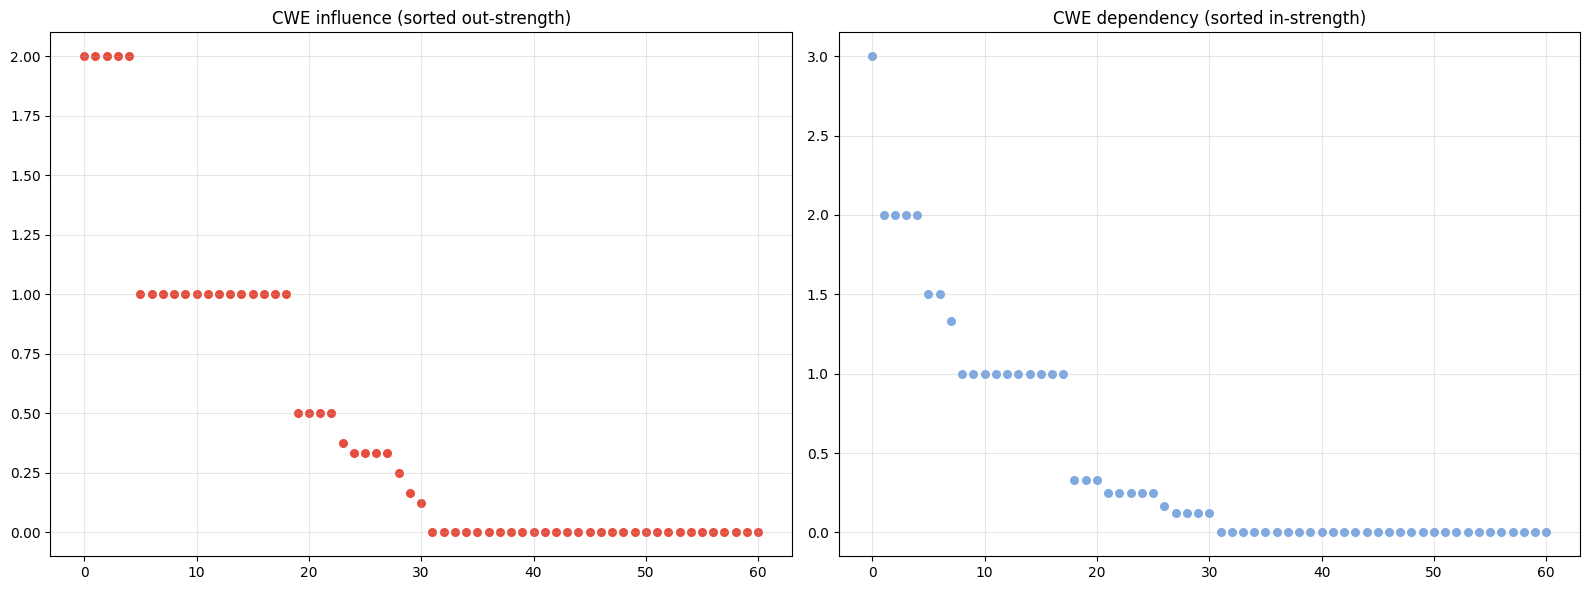

In [12]:
# === CWE plots: network, heatmap, curves (robusto ao KeyError) ===
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
from networkx.algorithms import community

UG = G_cwe.to_undirected()

# Se pr_norm não existir, calcule-o
try:
    pr_norm
except NameError:
    try:
        _pr = nx.pagerank(G_cwe, weight='weight')
    except Exception:
        _pr = {n: 0.0 for n in G_cwe.nodes()}
    if _pr:
        arr = np.array(list(_pr.values())); mn, mx = arr.min(), arr.max()
        pr_norm = {k: (v - mn) / (mx - mn + 1e-12) for k, v in _pr.items()}
    else:
        pr_norm = {n: 0.0 for n in G_cwe.nodes()}

# Comunidades
comms = list(community.greedy_modularity_communities(UG, weight='weight')) if UG.number_of_edges() > 0 else []
node2comm = {}
for i, c in enumerate(comms):
    for n in c:
        node2comm[n] = i

# Métricas alinhadas ao G_cwe atual
metrics_df_cwe = pd.DataFrame({
    'cwe': list(G_cwe.nodes()),
    'pagerank': [pr_norm.get(n, 0.0) for n in G_cwe.nodes()],
    'out_strength': [out_w.get(n, 0.0) for n in G_cwe.nodes()],
    'in_strength': [in_w.get(n, 0.0) for n in G_cwe.nodes()],
}).sort_values(['pagerank','out_strength'], ascending=False).reset_index(drop=True)

# 1) Network
pos = nx.spring_layout(G_cwe, weight='weight', seed=42, k=2) if G_cwe.number_of_edges() > 0 else {n: (i, 0) for i, n in enumerate(G_cwe.nodes())}
num_c = max(1, (max(node2comm.values()) + 1) if node2comm else 1)
cmap = plt.cm.tab20(np.linspace(0, 1, num_c))
node_color = [cmap[node2comm.get(n, 0)] for n in G_cwe.nodes()]
node_size = [1000 * (pr_norm.get(n, 0.0) + 1e-4) for n in G_cwe.nodes()]
edge_w = [d.get('weight', 0.1) * 3 for _, _, d in G_cwe.edges(data=True)]

fig, ax = plt.subplots(1, 1, figsize=(18, 12))
nx.draw_networkx_edges(G_cwe, pos, alpha=0.25, width=edge_w, arrows=True, arrowstyle='-|>', arrowsize=10, edge_color='gray', ax=ax)
nx.draw_networkx_nodes(G_cwe, pos, node_color=node_color, node_size=node_size, edgecolors='black', linewidths=1.2, ax=ax)
labels = {row['cwe']: row['cwe'] for _, row in metrics_df_cwe.head(12).iterrows()}
nx.draw_networkx_labels(G_cwe, pos, labels=labels, font_size=10, font_weight='bold', ax=ax)
ax.set_title('CWE Influence Network (directed, weight=P(B|A))', fontsize=16, fontweight='bold'); ax.axis('off')
plt.tight_layout(); plt.savefig('outputs/plots/cwe_influence_network.png', dpi=300, bbox_inches='tight'); plt.show()

# 2) Heatmap top 15 (por pagerank)
N = min(15, len(metrics_df_cwe))
order = metrics_df_cwe.head(N)['cwe'].tolist()
cond = np.zeros((N, N))
for i, a in enumerate(order):
    for j, b in enumerate(order):
        if G_cwe.has_edge(a, b):
            cond[i, j] = G_cwe.edges[a, b].get('weight', 0)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(cond, xticklabels=order, yticklabels=order, cmap='YlOrRd', cbar_kws={'label': 'P(B|A)'}, ax=ax)
plt.xticks(rotation=45, ha='right')
ax.set_title('CWE conditional probability (top 15)', fontsize=14, fontweight='bold')
plt.tight_layout(); plt.savefig('outputs/plots/cwe_conditional_heatmap.png', dpi=300, bbox_inches='tight'); plt.show()

# 3) Curves (out/in-strength)
vals_out = np.sort(metrics_df_cwe['out_strength'].values)[::-1]
vals_in  = np.sort(metrics_df_cwe['in_strength'].values)[::-1]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.scatter(range(len(vals_out)), vals_out, c='#e74c3c', s=30); ax1.set_title('CWE influence (sorted out-strength)'); ax1.grid(alpha=0.3)
ax2.scatter(range(len(vals_in)),  vals_in,  c='#7ea9e1', s=30); ax2.set_title('CWE dependency (sorted in-strength)'); ax2.grid(alpha=0.3)
plt.tight_layout(); plt.savefig('outputs/plots/cwe_influence_dependency_curves.png', dpi=300, bbox_inches='tight'); plt.show()